In [1]:
import pandas as pd
import numpy as np

In [2]:
dataset = pd.read_csv('data_healthcare/dataset.csv')
desc_sym = pd.read_csv('data_healthcare/symptom_Description.csv')
prec_sym = pd.read_csv('data_healthcare/symptom_precaution.csv')
sym_wight = pd.read_csv('data_healthcare/Symptom-severity.csv')

cleansing

In [3]:
#mengilangkan white space
dataset = dataset.apply(lambda x: x.str.strip())
dataset = dataset.replace('_',' ', regex=True).replace('  ',' ', regex=True).replace(' ofu',' of u', regex=True)
desc_sym = desc_sym.apply(lambda x: x.str.strip())
prec_sym = prec_sym.apply(lambda x: x.str.strip())

Split dataset (split in every disease)

In [4]:
from sklearn.model_selection import train_test_split
def df_split(dataset, test_size):
  df_train = pd.DataFrame()
  df_test = pd.DataFrame()
  for dis in dataset.Disease.unique().tolist():
    dataset_dis = dataset.loc[dataset.Disease == dis]
    train, test = train_test_split(dataset_dis, test_size=test_size, random_state=7)
    df_train = pd.concat([df_train, train])
    df_test = pd.concat([df_test, test])
  return df_train, df_test

In [5]:
train, test = df_split(dataset, 0.1)
print(len(dataset), len(train), len(test))

4920 4428 492


In [6]:
train.Disease.value_counts()

Fungal infection                          108
Hepatitis C                               108
Hepatitis E                               108
Alcoholic hepatitis                       108
Tuberculosis                              108
Common Cold                               108
Pneumonia                                 108
Dimorphic hemmorhoids(piles)              108
Heart attack                              108
Varicose veins                            108
Hypothyroidism                            108
Hyperthyroidism                           108
Hypoglycemia                              108
Osteoarthristis                           108
Arthritis                                 108
(vertigo) Paroymsal Positional Vertigo    108
Acne                                      108
Urinary tract infection                   108
Psoriasis                                 108
Hepatitis D                               108
Hepatitis B                               108
Allergy                           

In [7]:
test.Disease.value_counts()

Fungal infection                          12
Hepatitis C                               12
Hepatitis E                               12
Alcoholic hepatitis                       12
Tuberculosis                              12
Common Cold                               12
Pneumonia                                 12
Dimorphic hemmorhoids(piles)              12
Heart attack                              12
Varicose veins                            12
Hypothyroidism                            12
Hyperthyroidism                           12
Hypoglycemia                              12
Osteoarthristis                           12
Arthritis                                 12
(vertigo) Paroymsal Positional Vertigo    12
Acne                                      12
Urinary tract infection                   12
Psoriasis                                 12
Hepatitis D                               12
Hepatitis B                               12
Allergy                                   12
hepatitis 

In [8]:
# save train test dataset
train.to_csv('train_dataset.csv', index=False)
test.to_csv('test_dataset.csv',  index=False)

##  feature extraction

onehot encode

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [10]:
def df_symptoms_list(dataset):
    # symptoms to list
    dataset = pd.DataFrame({'Disease':dataset.Disease, 'Symptoms':dataset.drop(columns=['Disease']).values.tolist()})
    dataset['Symptoms'] = dataset.Symptoms.apply(lambda case: [symptom for symptom in case if str(symptom) != 'nan']) # remove nan value
    return dataset

In [11]:
def onehot_dataset(train, test):
    # Symptoms to list
    train_list = df_symptoms_list(train)
    test_list = df_symptoms_list(test)

    # Symptoms_list to onehot
    mlb = MultiLabelBinarizer(sparse_output=True)

    train_mlb = pd.DataFrame.sparse.from_spmatrix(
                    mlb.fit_transform(train_list.Symptoms),
                    index=train_list.index,
                    columns=mlb.classes_)
    test_mlb = pd.DataFrame.sparse.from_spmatrix(
                    mlb.transform(test_list.Symptoms),
                    index=test_list.index,
                    columns=mlb.classes_)
    
    X_train = np.array(train_mlb)
    X_test = np.array(test_mlb)

    # Label/Disease to onehot
    enc = OneHotEncoder(handle_unknown='ignore')
    y_train = enc.fit_transform(train[['Disease']]).toarray()
    y_test = np.array(test[['Disease']])

    return X_train, X_test, y_train, y_test, mlb, enc

In [12]:
X_train, X_test, y_train, y_test, mlb, enc = onehot_dataset(train, test)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=7)

In [14]:
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(3985, 131) (443, 131) (492, 131) (3985, 41) (443, 41) (492, 1)


In [15]:
print(len(mlb.classes_), len(enc.categories_[0]))

131 41


# Model

### neural network

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [17]:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu')),
model.add(Dense(128, activation='relu')),
model.add(Dropout(0.3)),
model.add(Dense(y_train.shape[1], activation='sigmoid')),

(None,)

In [18]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                8448      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 41)                5289      
                                                                 
Total params: 22,057
Trainable params: 22,057
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=10,
          verbose=2)

Epoch 1/10
125/125 - 1s - loss: 2.1913 - accuracy: 0.7014 - val_loss: 0.3430 - val_accuracy: 1.0000 - 678ms/epoch - 5ms/step
Epoch 2/10
125/125 - 0s - loss: 0.1531 - accuracy: 0.9937 - val_loss: 0.0270 - val_accuracy: 1.0000 - 205ms/epoch - 2ms/step
Epoch 3/10
125/125 - 0s - loss: 0.0364 - accuracy: 0.9992 - val_loss: 0.0086 - val_accuracy: 1.0000 - 175ms/epoch - 1ms/step
Epoch 4/10
125/125 - 0s - loss: 0.0165 - accuracy: 0.9997 - val_loss: 0.0041 - val_accuracy: 1.0000 - 162ms/epoch - 1ms/step
Epoch 5/10
125/125 - 0s - loss: 0.0104 - accuracy: 0.9997 - val_loss: 0.0024 - val_accuracy: 1.0000 - 165ms/epoch - 1ms/step
Epoch 6/10
125/125 - 0s - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000 - 159ms/epoch - 1ms/step
Epoch 7/10
125/125 - 0s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 9.9900e-04 - val_accuracy: 1.0000 - 165ms/epoch - 1ms/step
Epoch 8/10
125/125 - 0s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 7.2308e-04 - val_accuracy: 1.0000 - 157ms/epoch - 1

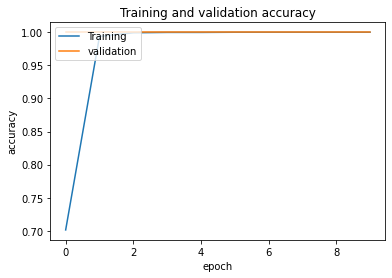

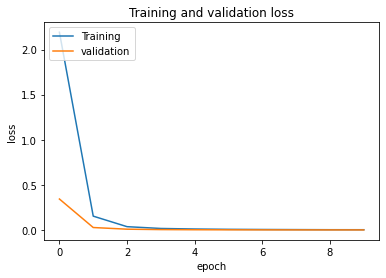

In [20]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'validation'], loc='upper left')
plt.show()

In [21]:
y_pred = enc.inverse_transform(model.predict(X_test))
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

16/16 [==============================] - 0s 731us/step
[[12  0  0 ...  0  0  0]
 [ 0 12  0 ...  0  0  0]
 [ 0  0 12 ...  0  0  0]
 ...
 [ 0  0  0 ... 12  0  0]
 [ 0  0  0 ...  0 12  0]
 [ 0  0  0 ...  0  0 12]]


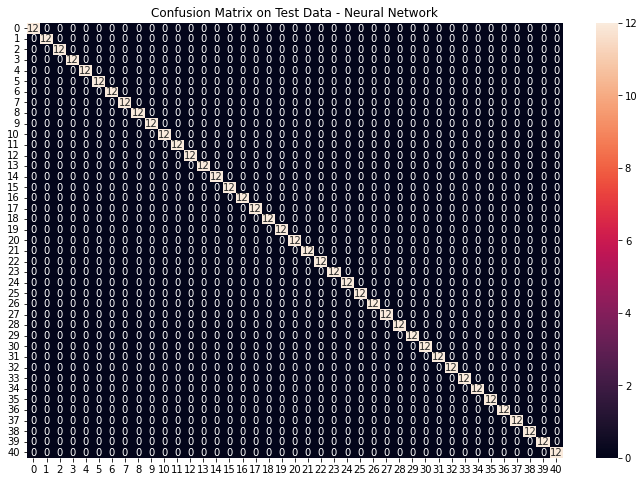

In [22]:
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix on Test Data - Neural Network")
plt.show()

In [23]:
model.save('model/Classification_Disease.h5')

In [24]:
import joblib

In [25]:
joblib.dump(enc, 'model/label_ohe.pkl')
joblib.dump(mlb, 'model/symps_ohe.pkl')

['model/symps_ohe.pkl']

# Deploy

In [26]:
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
import itertools
import numpy as np

In [27]:
dis_pred_model = load_model('model/Classification_Disease.h5')

In [28]:
enc = joblib.load('model/label_ohe.pkl')

In [29]:
mlb = joblib.load('model/symps_ohe.pkl')

In [30]:
all_symptom_data = mlb.classes_.tolist()

In [31]:
#one hot encoding symtomps
def onehot_sym(symptoms:list, all_symptom_data=all_symptom_data):
    matrix_sym = [0] * len(all_symptom_data) #inisiate onehot matrix
    for symptom in symptoms:
        try:
            index = all_symptom_data.index(symptom)
            matrix_sym[index] = 1
        except:pass # pass, when the symptom not in all_symptom_data
    return np.array(matrix_sym).reshape(1,-1)

In [32]:
def clean(symptoms):
    sym = symptoms.split(',')
    sym = [s.strip() for s in sym]
    return sym

test

In [33]:
a = '''abdominal pain ,  acidity, anxiety'''
a = clean(a)
a = onehot_sym(a)
result = enc.inverse_transform(dis_pred_model.predict(a))[0][0]
proba =  np.max(model.predict(a))
print(f"{result} : {proba}\n")

1/1 [==============================] - 0s 15ms/step
GERD : 0.1704917997121811



In [34]:
b = '''infection,itching,skin rash,nodal skin eruptions,dischromic patches'''
b = clean(b)
b = onehot_sym(b)
result = enc.inverse_transform(dis_pred_model.predict(b))[0][0]
proba =  np.max(model.predict(b))
print(f"{result} : {proba}\n")

1/1 [==============================] - 0s 16ms/step
Fungal infection : 0.9998572468757629

